In [79]:
import numpy as np
from scipy.integrate import solve_ivp
import pandas as pd
import matplotlib.pyplot as plt
from reservoirpy.observables import nrmse, rsquare

import reservoirpy as rpy

rpy.verbosity(0)

from reservoirpy.nodes import Reservoir, Ridge
from reservoirpy.datasets import mackey_glass

外力がより複雑な場合を考えてみる。
試しに、外力の項がローレンツシステムのx成分であるときを考えてみる。

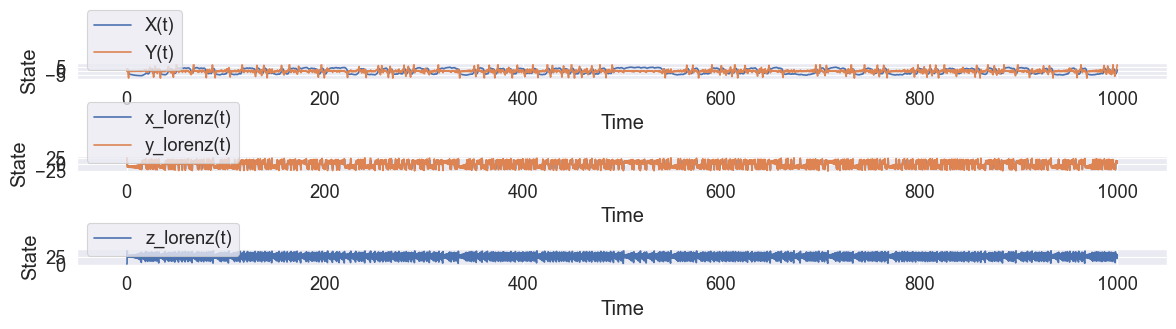

In [80]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

def coupled_system(t, state, mu, sigma, rho, beta):
    X, Y, x_lorenz, y_lorenz, z_lorenz = state
    
    dXdt = Y
    dYdt = mu * (1 - X**2) * Y - X + x_lorenz
    
    dx_lorenz_dt = sigma * (y_lorenz - x_lorenz)
    dy_lorenz_dt = x_lorenz * (rho - z_lorenz) - y_lorenz
    dz_lorenz_dt = x_lorenz * y_lorenz - beta * z_lorenz
    
    return [dXdt, dYdt, dx_lorenz_dt, dy_lorenz_dt, dz_lorenz_dt]

mu = 1.0
sigma = 10.0
rho = 28.0
beta = 8/3
initial_state = [1.0, 0.0, 1.0, 1.0, 1.0]  # Initial states for [X, Y, x_lorenz, y_lorenz, z_lorenz]
t_span = (0, 1000)

sol = solve_ivp(coupled_system, t_span, initial_state, args=(mu, sigma, rho, beta), t_eval=np.linspace(t_span[0], t_span[1], 10000))

# Plot the results
plt.figure(figsize=(12, 3))

plt.subplot(3, 1, 1)
plt.plot(sol.t, sol.y[0], label='X(t)')
plt.plot(sol.t, sol.y[1], label='Y(t)')
plt.xlabel('Time')
plt.ylabel('State')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(sol.t, sol.y[2], label='x_lorenz(t)')
plt.plot(sol.t, sol.y[3], label='y_lorenz(t)')
plt.xlabel('Time')
plt.ylabel('State')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(sol.t, sol.y[4], label='z_lorenz(t)')
plt.xlabel('Time')
plt.ylabel('State')
plt.legend()

plt.tight_layout()
plt.show()


In [81]:
data = pd.DataFrame({
    'Time': sol.t,
    'X': sol.y[0],
    'Y': sol.y[1],
    'x_lorenz': sol.y[2],
    'y_lorenz': sol.y[3],
    'z_lorenz': sol.y[4]
})

# DataFrameをCSVファイルに保存
data.to_csv('coupled_system_dataset.csv', index=False)

In [82]:
data_loaded = pd.read_csv('forced_vanderpol_dataset.csv')

In [83]:
X = data.values

In [84]:
X

array([[0.00000000e+00, 1.00000000e+00, 0.00000000e+00, 1.00000000e+00,
        1.00000000e+00, 1.00000000e+00],
       [1.00010001e-01, 1.00095630e+00, 3.78727253e-02, 2.13333131e+00,
        4.47197977e+00, 1.11394353e+00],
       [2.00020002e-01, 1.01578928e+00, 3.30914780e-01, 6.53674299e+00,
        1.37100231e+01, 4.17683595e+00],
       ...,
       [9.99799980e+02, 1.21129191e-01, 6.25516949e+00, 5.96858509e+00,
        8.36469376e+00, 1.94254696e+01],
       [9.99899990e+02, 8.08096259e-01, 7.46723055e+00, 9.18481031e+00,
        1.30137583e+01, 2.20969499e+01],
       [1.00000000e+03, 1.59463216e+00, 8.05167502e+00, 1.22604653e+01,
        1.34945851e+01, 3.04999750e+01]])

In [85]:
def plot_vanderpol_3d(X, timesteps):
    # 3D プロットの作成
    fig = plt.figure(figsize=(10, 10))
    ax  = fig.add_subplot(111, projection='3d')
    ax.set_title("Van Der Pol Oscillator")
    ax.set_xlabel("t")
    ax.set_ylabel("x")
    ax.set_zlabel("y")
    ax.grid(False)

    for i in range(timesteps-1):
        ax.plot(X[i:i+2, 0], X[i:i+2, 1], X[i:i+2, 2], color=plt.cm.cividis(255*i//timesteps), lw=1.0)

    plt.show()

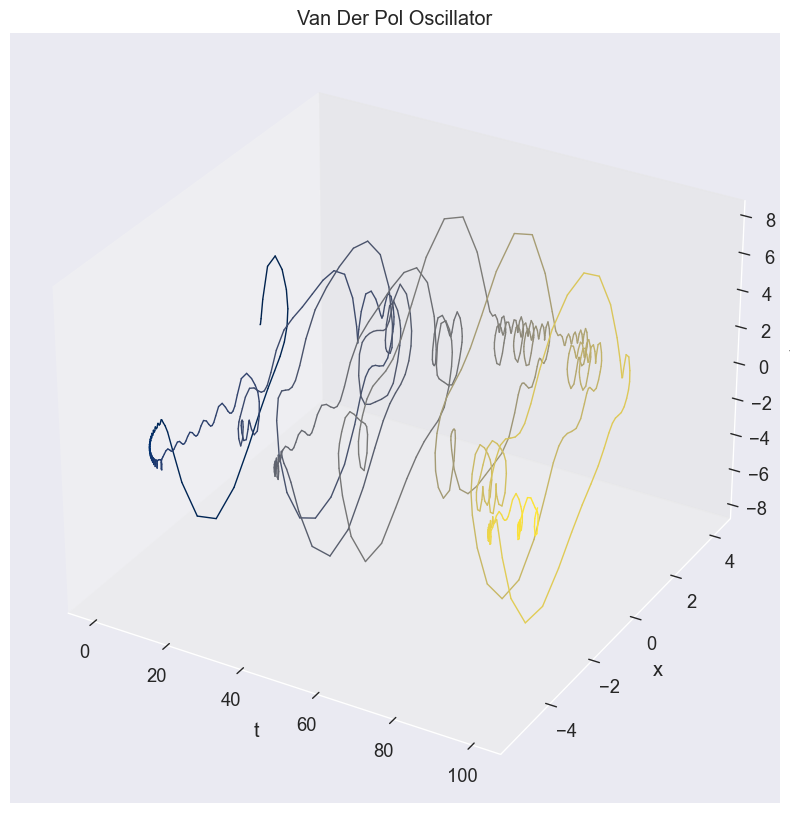

In [86]:
plot_vanderpol_3d(X, 1000)

In [87]:
# Objective functions accepted by ReservoirPy must respect some conventions:
#  - dataset and config arguments are mandatory, like the empty '*' expression.
#  - all parameters that will be used during the search must be placed after the *.
#  - the function must return a dict with at least a 'loss' key containing the result
# of the loss function. You can add any additional metrics or information with other 
# keys in the dict. See hyperopt documentation for more informations.
def objective(dataset, config, *, iss, N, sr, lr, ridge, seed):
    
    # This step may vary depending on what you put inside 'dataset'
    train_data, validation_data = dataset
    X_train, y_train = train_data
    X_val, y_val = validation_data
    
    # You can access anything you put in the config 
    # file from the 'config' parameter.
    instances = config["instances_per_trial"]
    
    # The seed should be changed across the instances, 
    # to be sure there is no bias in the results 
    # due to initialization.
    variable_seed = seed 
    
    losses = []; r2s = [];
    for n in range(instances):
        # Build your model given the input parameters
        reservoir = Reservoir(N, 
                              sr=sr, 
                              lr=lr, 
                              input_scaling=iss, 
                              seed=variable_seed)
        
        readout = Ridge(ridge=ridge)

        model = reservoir >> readout


        # Train your model and test your model.
        predictions = model.fit(X_train, y_train) \
                           .run(X_test)
        
        loss = nrmse(y_test, predictions, norm_value=np.ptp(X_train))
        r2 = rsquare(y_test, predictions)
        
        # Change the seed between instances
        variable_seed += 1
        
        losses.append(loss)
        r2s.append(r2)

    # Return a dictionnary of metrics. The 'loss' key is mandatory when
    # using hyperopt.
    return {'loss': np.mean(losses),
            'r2': np.mean(r2s)}

In [88]:
hyperopt_config = {
    "exp": f"hyperopt-multiscroll", # the experimentation name
    "hp_max_evals": 200,             # the number of differents sets of parameters hyperopt has to try
    "hp_method": "random",           # the method used by hyperopt to chose those sets (see below)
    "seed": 42,                      # the random state seed, to ensure reproducibility
    "instances_per_trial": 3,        # how many random ESN will be tried with each sets of parameters
    "hp_space": {                    # what are the ranges of parameters explored
        "N": ["choice", 500],             # the number of neurons is fixed to 500
        "sr": ["loguniform", 1e-2, 10],   # the spectral radius is log-uniformly distributed between 1e-2 and 10
        "lr": ["loguniform", 1e-3, 1],  # idem with the leaking rate, from 1e-3 to 1
        "iss": ["choice", 0.9],           # the input scaling is fixed
        "ridge": ["choice", 1e-7],        # and so is the regularization parameter.
        "seed": ["choice", 1234]          # an other random seed for the ESN initialization
    }
}


import json

# we precautionously save the configuration in a JSON file
# each file will begin with a number corresponding to the current experimentation run number.
with open(f"{hyperopt_config['exp']}.config.json", "w+") as f:
    json.dump(hyperopt_config, f)

In [89]:
train_len = 100

X_train = X[:train_len]
y_train = X[1 : train_len + 1]

X_test = X[train_len : -1]
y_test = X[train_len + 1:]

dataset = ((X_train, y_train), (X_test, y_test))

In [90]:
%time 

from reservoirpy.hyper import research

best = research(objective, dataset, f"{hyperopt_config['exp']}.config.json", ".")

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 3.1 µs
  9%|▉         | 18/200 [04:12<42:36, 14.04s/trial, best loss: 3.9251139224819838]


KeyboardInterrupt: 

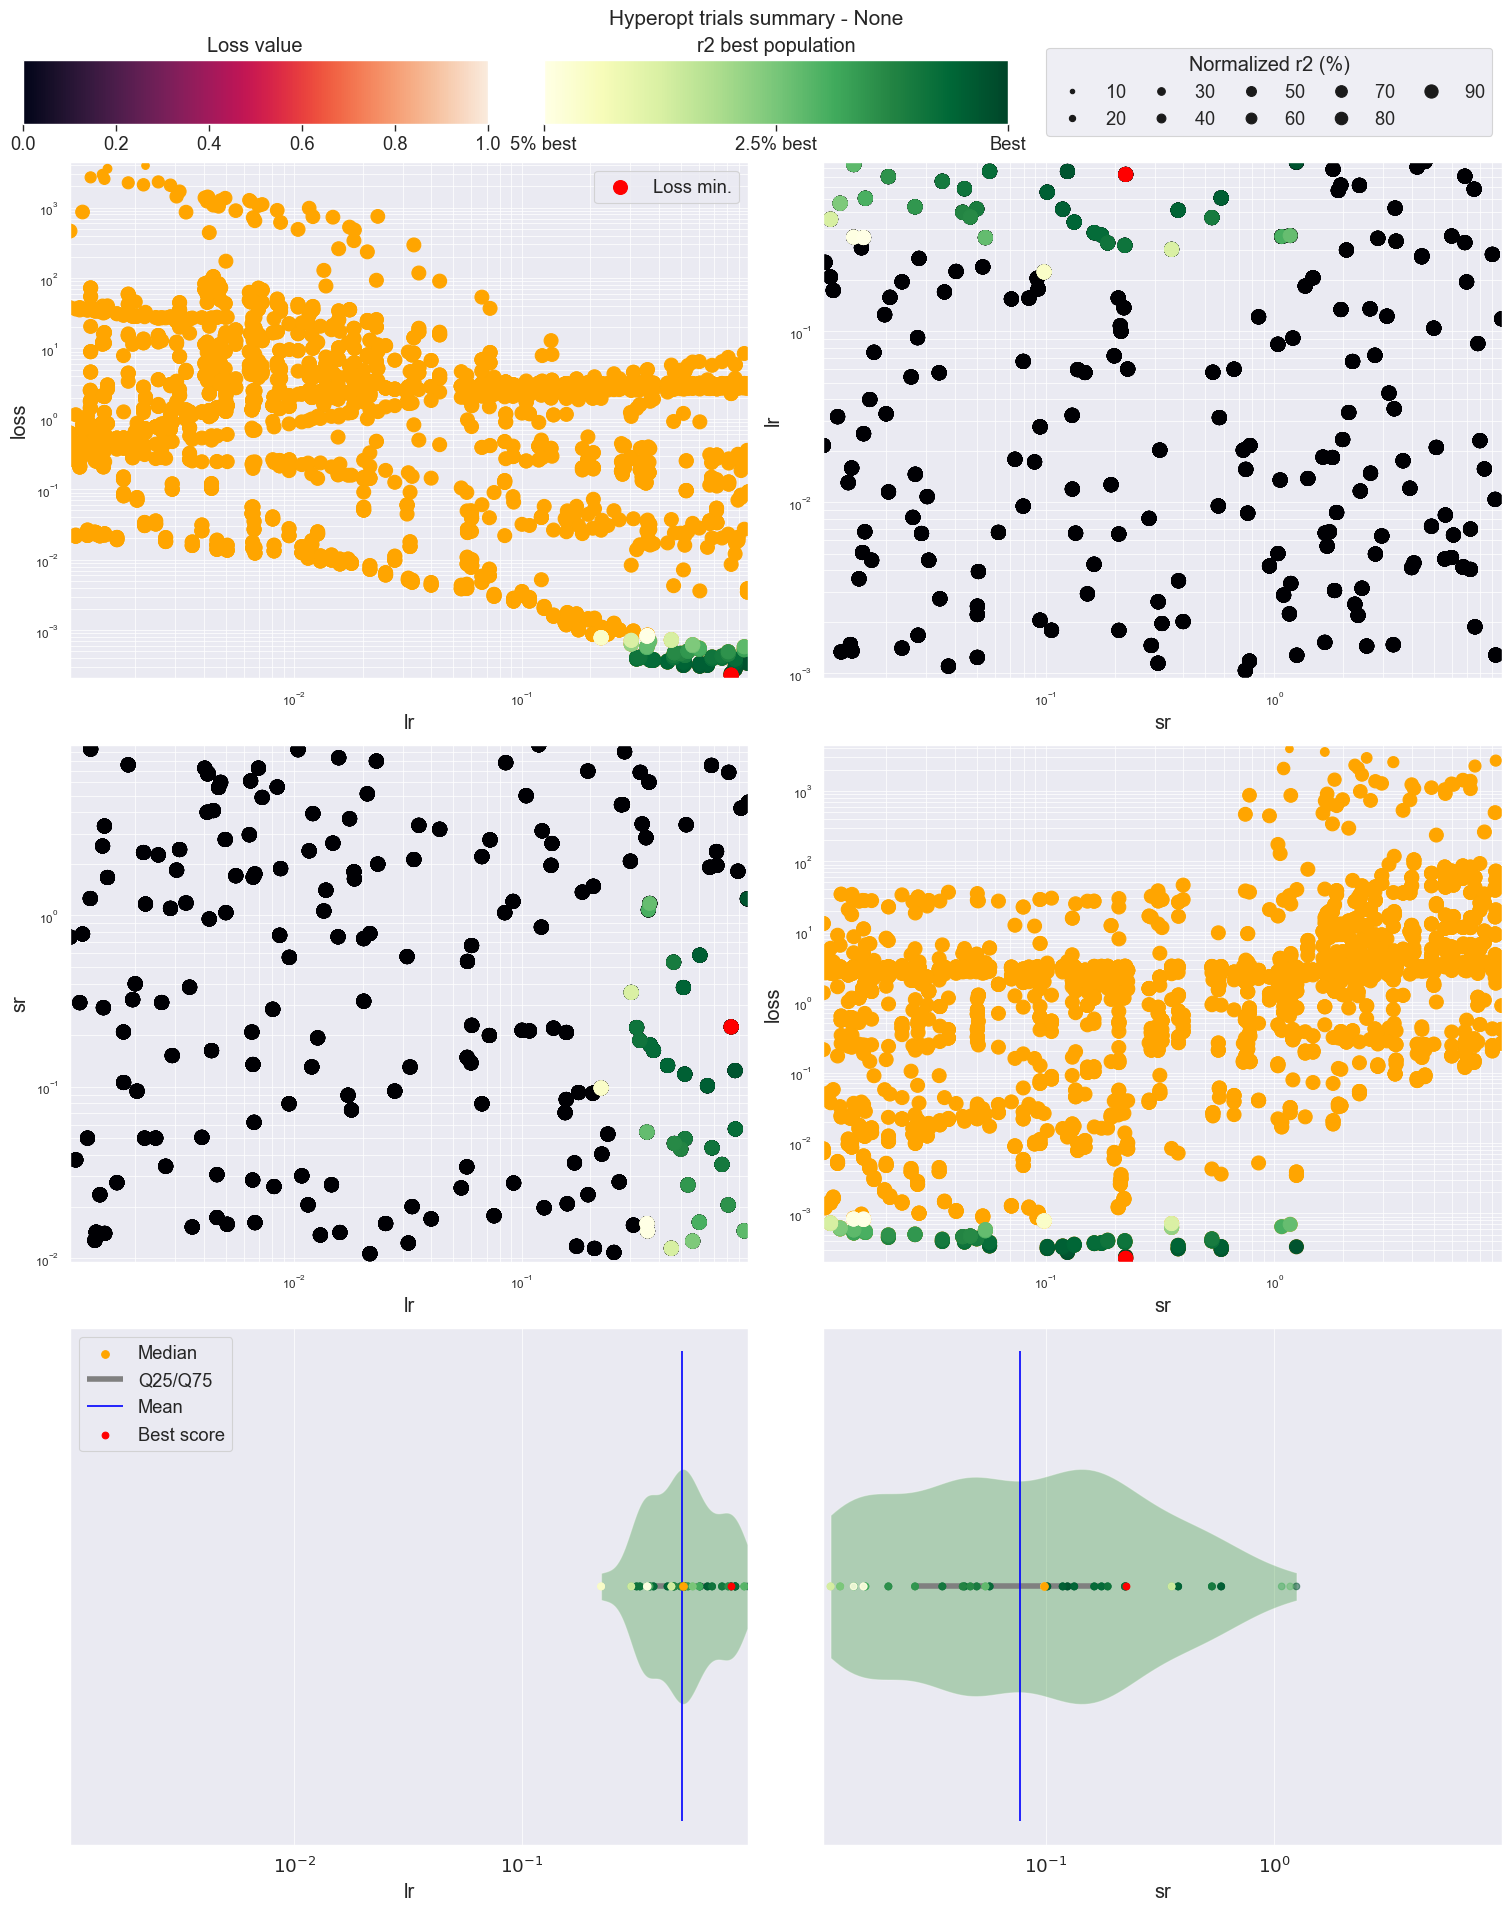

In [ ]:
from reservoirpy.hyper import plot_hyperopt_report

fig = plot_hyperopt_report(hyperopt_config["exp"], ("lr", "sr"), metric="r2")

In [ ]:
best

({'N': 0,
  'iss': 0,
  'lr': 0.8108075271225141,
  'ridge': 0,
  'seed': 0,
  'sr': 6.834465647289925},
 <hyperopt.base.Trials at 0x106414610>)

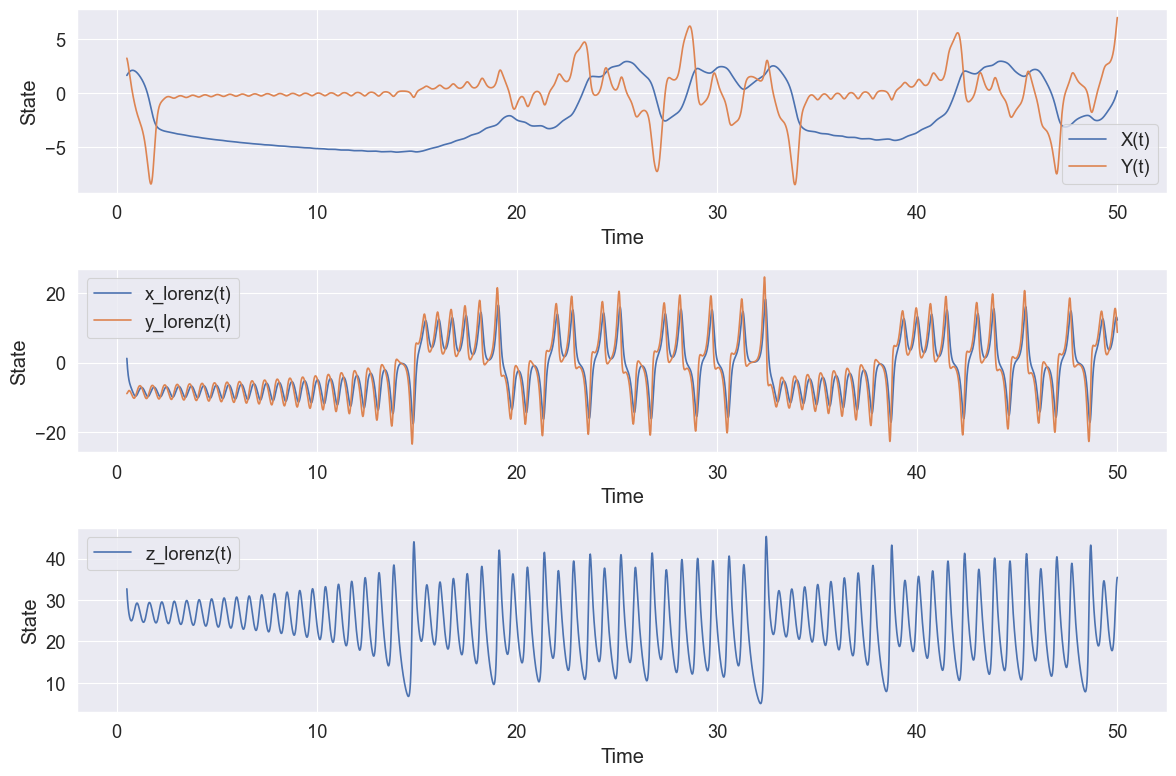

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 仮定: X_testの最初の列は時間、残りの列は状態変数
time_values = X_test[:, 0]
state_values = X_test[:, 1:].T  # 転置して状態変数を列として取得

# Plot the results
plt.figure(figsize=(12, 3))

plt.subplot(3, 1, 1)
plt.plot(time_values, state_values[0], label='X(t)')
plt.plot(time_values, state_values[1], label='Y(t)')
plt.xlabel('Time')
plt.ylabel('State')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(time_values, state_values[2], label='x_lorenz(t)')
plt.plot(time_values, state_values[3], label='y_lorenz(t)')
plt.xlabel('Time')
plt.ylabel('State')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(time_values, state_values[4], label='z_lorenz(t)')
plt.xlabel('Time')
plt.ylabel('State')
plt.legend()

plt.tight_layout()
plt.show()

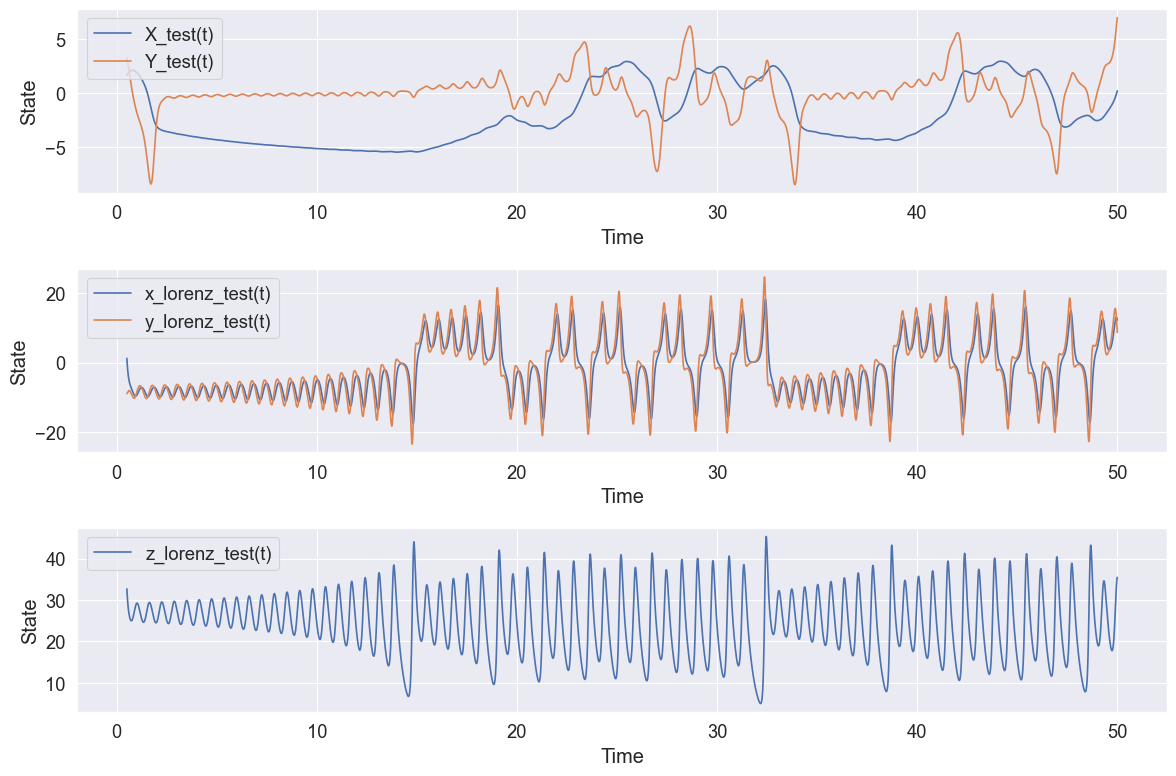

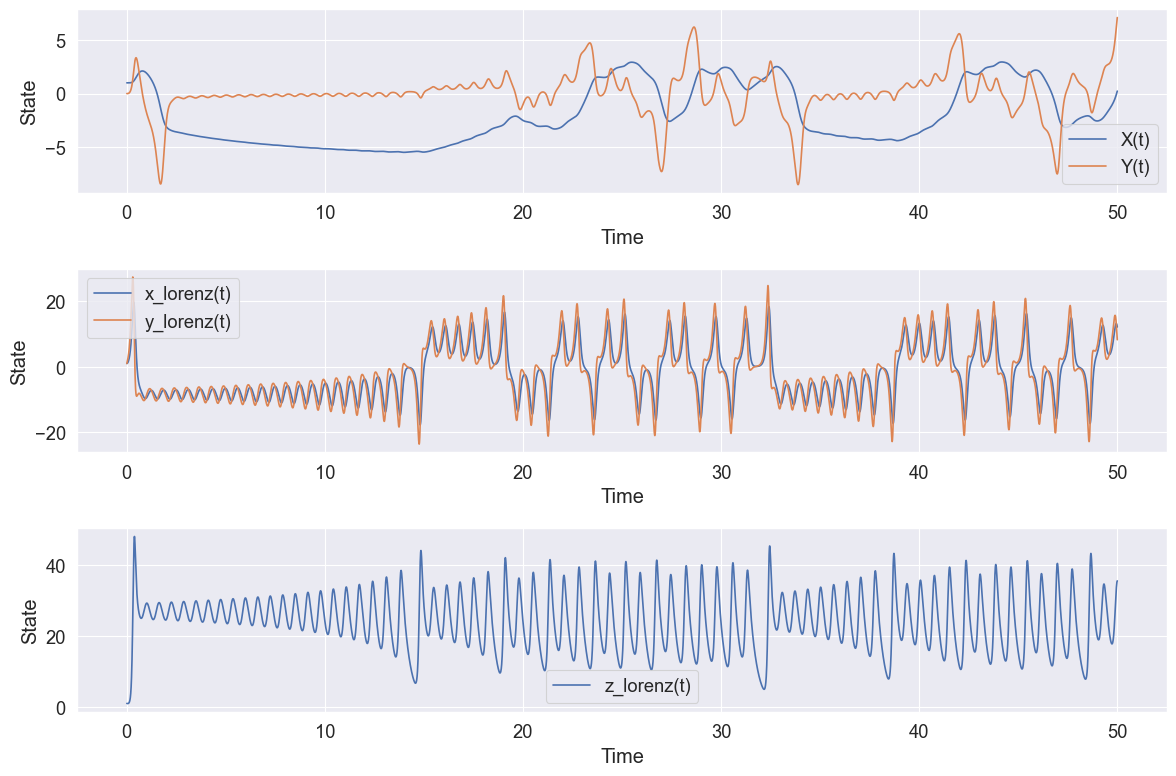

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# X_test のグラフ
time_values_test = X_test[:, 0]
state_values_test = X_test[:, 1:].T

plt.figure(figsize=(12, 3))

plt.subplot(3, 1, 1)
plt.plot(time_values_test, state_values_test[0], label='X_test(t)')
plt.plot(time_values_test, state_values_test[1], label='Y_test(t)')
plt.xlabel('Time')
plt.ylabel('State')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(time_values_test, state_values_test[2], label='x_lorenz_test(t)')
plt.plot(time_values_test, state_values_test[3], label='y_lorenz_test(t)')
plt.xlabel('Time')
plt.ylabel('State')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(time_values_test, state_values_test[4], label='z_lorenz_test(t)')
plt.xlabel('Time')
plt.ylabel('State')
plt.legend()

plt.tight_layout()
plt.show()

# X のグラフ
time_values_X = X[:, 0]
state_values_X = X[:, 1:].T

plt.figure(figsize=(12, 3))

plt.subplot(3, 1, 1)
plt.plot(time_values_X, state_values_X[0], label='X(t)')
plt.plot(time_values_X, state_values_X[1], label='Y(t)')
plt.xlabel('Time')
plt.ylabel('State')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(time_values_X, state_values_X[2], label='x_lorenz(t)')
plt.plot(time_values_X, state_values_X[3], label='y_lorenz(t)')
plt.xlabel('Time')
plt.ylabel('State')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(time_values_X, state_values_X[4], label='z_lorenz(t)')
plt.xlabel('Time')
plt.ylabel('State')
plt.legend()

plt.tight_layout()
plt.show()

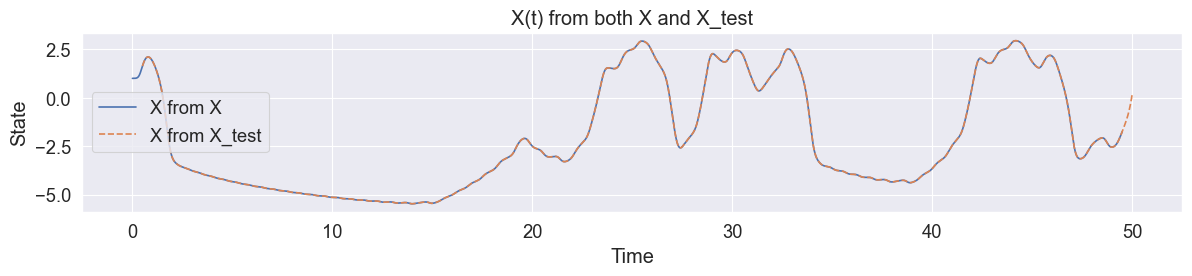

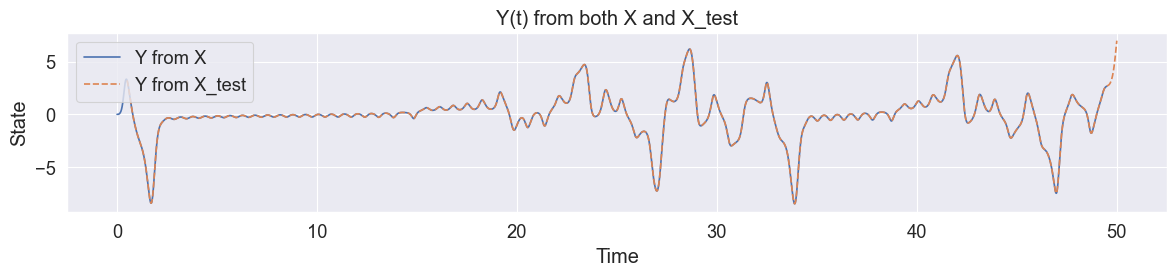

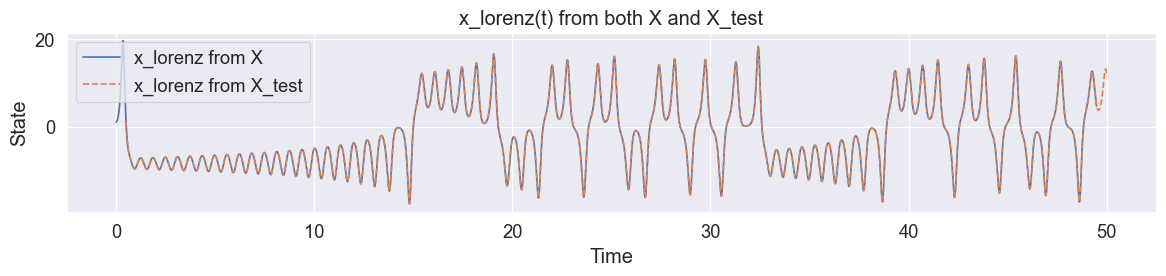

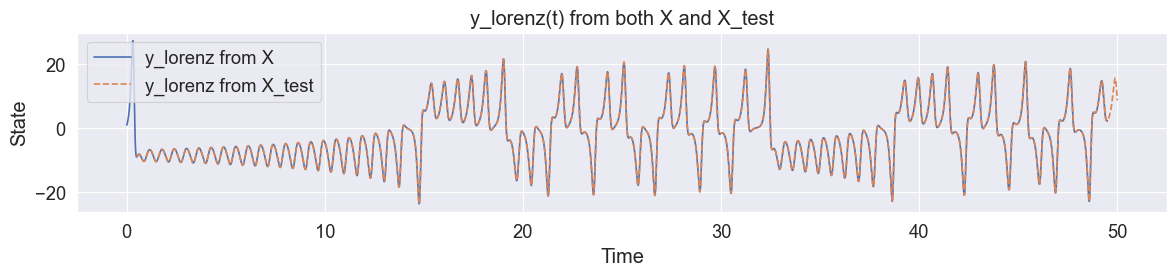

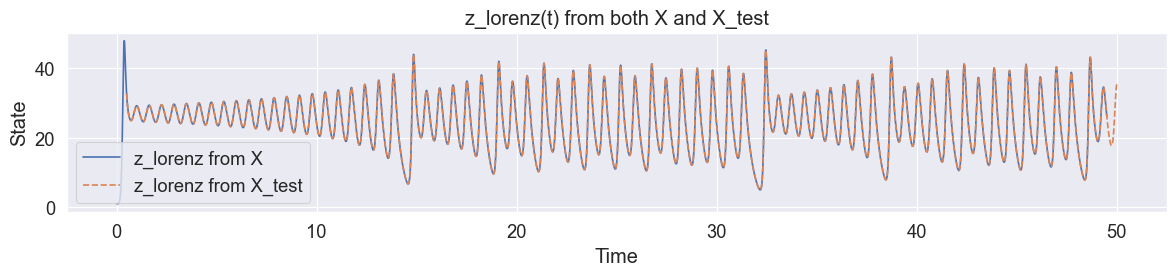

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# X_test のデータ
time_values_test = X_test[:, 0]
state_values_test = X_test[:, 1:].T

# X のデータ
time_values_X = X[:, 0]
state_values_X = X[:, 1:].T

# サイズが小さい方の配列の長さを取得
min_length = min(len(time_values_X), len(time_values_test))

# 1. X(t) のグラフ
plt.figure(figsize=(12, 3))
plt.plot(time_values_X[:min_length], state_values_X[0][:min_length], label='X from X')
plt.plot(time_values_test[:min_length], state_values_test[0][:min_length], label='X from X_test', linestyle='--')
plt.xlabel('Time')
plt.ylabel('State')
plt.legend()
plt.title('X(t) from both X and X_test')
plt.tight_layout()
plt.show()

# 2. Y(t) のグラフ
plt.figure(figsize=(12, 3))
plt.plot(time_values_X[:min_length], state_values_X[1][:min_length], label='Y from X')
plt.plot(time_values_test[:min_length], state_values_test[1][:min_length], label='Y from X_test', linestyle='--')
plt.xlabel('Time')
plt.ylabel('State')
plt.legend()
plt.title('Y(t) from both X and X_test')
plt.tight_layout()
plt.show()

# 3. x_lorenz(t) のグラフ
plt.figure(figsize=(12, 3))
plt.plot(time_values_X[:min_length], state_values_X[2][:min_length], label='x_lorenz from X')
plt.plot(time_values_test[:min_length], state_values_test[2][:min_length], label='x_lorenz from X_test', linestyle='--')
plt.xlabel('Time')
plt.ylabel('State')
plt.legend()
plt.title('x_lorenz(t) from both X and X_test')
plt.tight_layout()
plt.show()

# 4. y_lorenz(t) のグラフ
plt.figure(figsize=(12, 3))
plt.plot(time_values_X[:min_length], state_values_X[3][:min_length], label='y_lorenz from X')
plt.plot(time_values_test[:min_length], state_values_test[3][:min_length], label='y_lorenz from X_test', linestyle='--')
plt.xlabel('Time')
plt.ylabel('State')
plt.legend()
plt.title('y_lorenz(t) from both X and X_test')
plt.tight_layout()
plt.show()

# 5. z_lorenz(t) のグラフ
plt.figure(figsize=(12, 3))
plt.plot(time_values_X[:min_length], state_values_X[4][:min_length], label='z_lorenz from X')
plt.plot(time_values_test[:min_length], state_values_test[4][:min_length], label='z_lorenz from X_test', linestyle='--')
plt.xlabel('Time')
plt.ylabel('State')
plt.legend()
plt.title('z_lorenz(t) from both X and X_test')
plt.tight_layout()
plt.show()


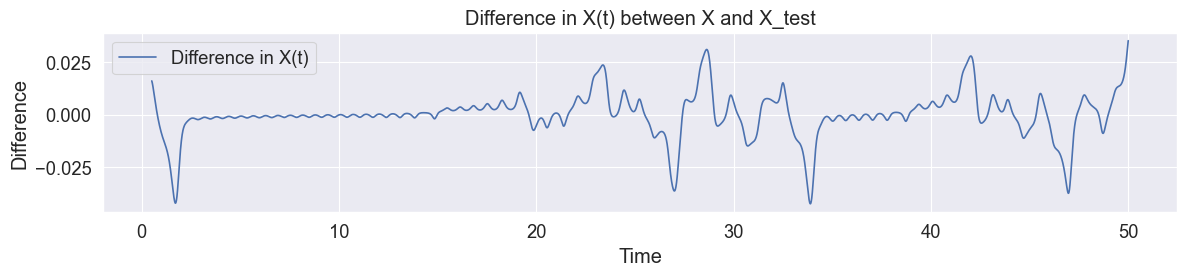

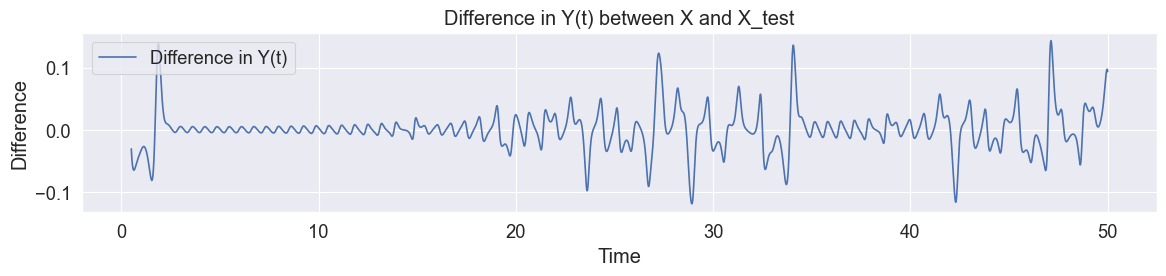

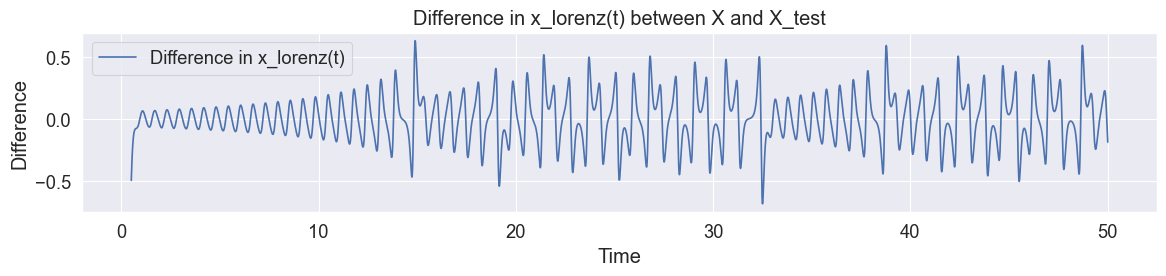

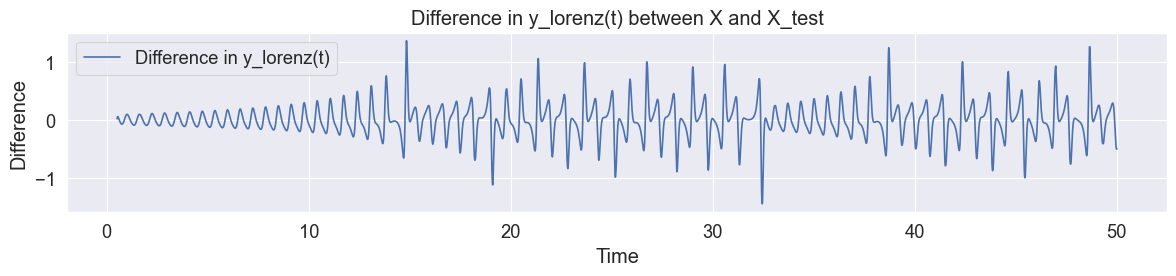

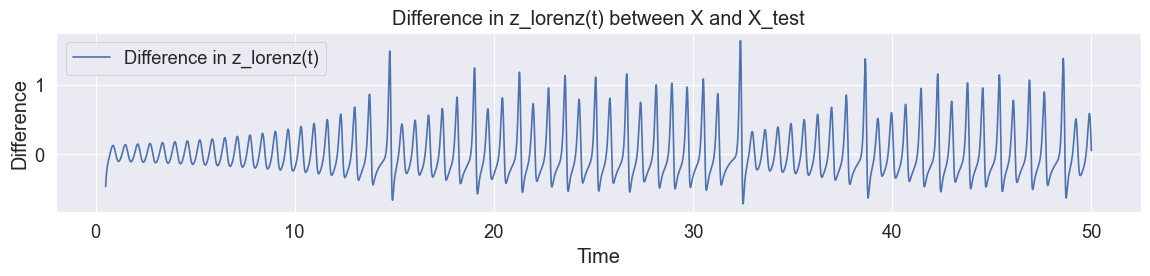

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# X_test のデータ
time_values_test = X_test[:, 0]
state_values_test = X_test[:, 1:].T

# X のデータ
time_values_X = X[:, 0]
state_values_X = X[:, 1:].T

# 両方のデータが同じ終了時点を持つようにXの先頭部分をトリム
offset = len(time_values_X) - len(time_values_test)
time_values_X = time_values_X[offset:]
state_values_X = state_values_X[:, offset:]

# 描画
# 1. X(t) の差分のグラフ
plt.figure(figsize=(12, 3))
plt.plot(time_values_X, state_values_X[0] - state_values_test[0], label='Difference in X(t)')
plt.xlabel('Time')
plt.ylabel('Difference')
plt.legend()
plt.title('Difference in X(t) between X and X_test')
plt.tight_layout()
plt.show()

# 2. Y(t) の差分のグラフ
plt.figure(figsize=(12, 3))
plt.plot(time_values_X, state_values_X[1] - state_values_test[1], label='Difference in Y(t)')
plt.xlabel('Time')
plt.ylabel('Difference')
plt.legend()
plt.title('Difference in Y(t) between X and X_test')
plt.tight_layout()
plt.show()

# 3. x_lorenz(t) の差分のグラフ
plt.figure(figsize=(12, 3))
plt.plot(time_values_X, state_values_X[2] - state_values_test[2], label='Difference in x_lorenz(t)')
plt.xlabel('Time')
plt.ylabel('Difference')
plt.legend()
plt.title('Difference in x_lorenz(t) between X and X_test')
plt.tight_layout()
plt.show()

# 4. y_lorenz(t) の差分のグラフ
plt.figure(figsize=(12, 3))
plt.plot(time_values_X, state_values_X[3] - state_values_test[3], label='Difference in y_lorenz(t)')
plt.xlabel('Time')
plt.ylabel('Difference')
plt.legend()
plt.title('Difference in y_lorenz(t) between X and X_test')
plt.tight_layout()
plt.show()

# 5. z_lorenz(t) の差分のグラフ
plt.figure(figsize=(12, 3))
plt.plot(time_values_X, state_values_X[4] - state_values_test[4], label='Difference in z_lorenz(t)')
plt.xlabel('Time')
plt.ylabel('Difference')
plt.legend()
plt.title('Difference in z_lorenz(t) between X and X_test')
plt.tight_layout()
plt.show()


In [ ]:
X_test

array([[ 0.50005001,  1.6340038 ,  3.22464963,  1.21174644, -8.95339755,
        32.68810975],
       [ 0.50505051,  1.65005278,  3.19402169,  0.71645421, -8.93083312,
        32.21271211],
       [ 0.51005101,  1.66594034,  3.16033595,  0.24666325, -8.89703502,
        31.76533697],
       ...,
       [49.9849985 ,  0.12606727,  6.80176635, 12.6063096 ,  9.72974161,
        35.24937959],
       [49.989999  ,  0.16032213,  6.89730281, 12.45231082,  9.22892946,
        35.37355779],
       [49.9949995 ,  0.19505149,  6.99192944, 12.28165643,  8.72835255,
        35.45738896]])

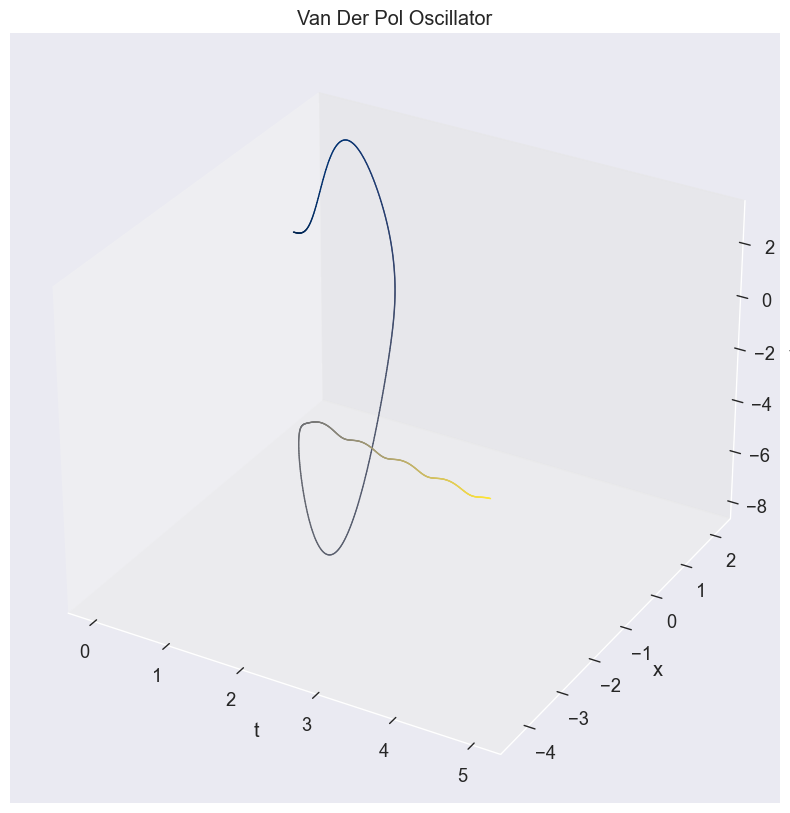

In [ ]:
plot_vanderpol_3d(X, 1000)

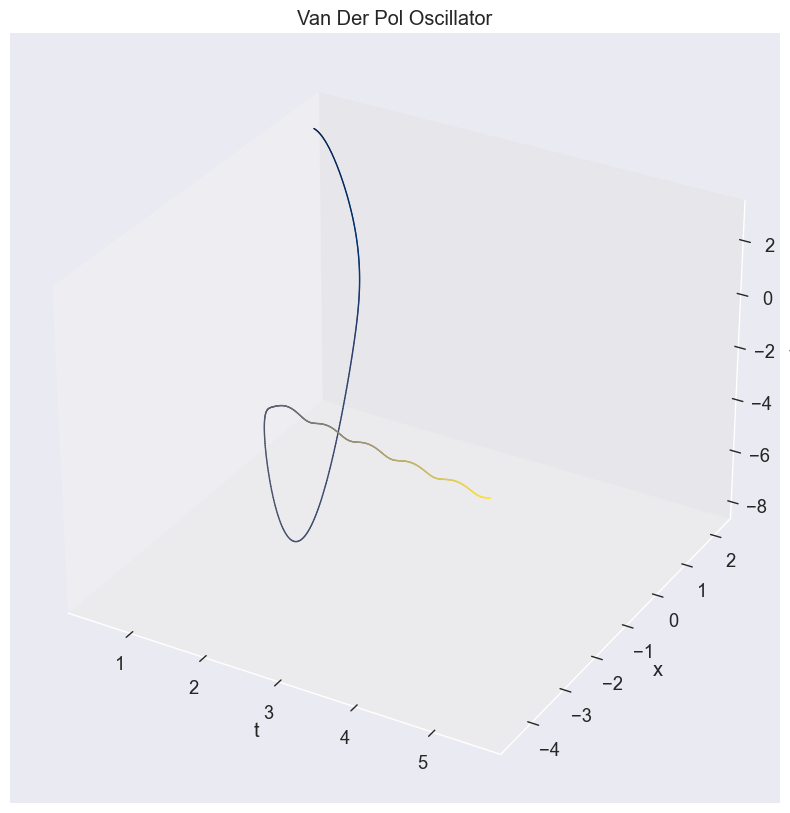

In [ ]:
plot_vanderpol_3d(X_test, 1000)